In [1]:
import pandas as pd
import os
import re

import time
import datetime
from datetime import datetime
import pytz

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
def parse_danmu(text):
    """
    Adapted from https://blog.csdn.net/kimol_justdo/article/details/110160627
    """
    result = []
    data = re.findall('<d p="(.*?)">(.*?)</d>', text)
    
    for d in data:
        item = {}
        dm = d[0].split(',')
        item['vid_time'] = float(dm[0])
        # 弹幕的模式，1-3 滚动弹幕，4 底端弹幕，5 顶端弹幕，6 逆向弹幕，7 精准定位，8 高级弹幕
        item['mode'] = int(dm[1])
        # 12非常小，16特小，18小，25中，36大，45很大，64特别大
        item['font_size'] = int(dm[2])
        item['font_color'] = int(dm[3])     
        item['comment_time'] = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(int(dm[4])))
        item['pool'] = int(dm[5])
        item['ID'] = dm[6]
        item['rowID'] = dm[7]
        item['content'] = d[1]
        
        result.append(item)
    
    return result

In [3]:
def convert_datetime_timezone(dt, tz1, tz2):
    """
    Convert from timezone 1 to timezone 2
    """
    tz1 = pytz.timezone(tz1)
    tz2 = pytz.timezone(tz2)

    dt = pd.to_datetime(dt)    
    dt = tz1.localize(dt)
    dt = dt.astimezone(tz2)
    dt = dt.strftime("%Y-%m-%d %H:%M:%S")

    return dt

In [4]:
def read_danmu(filename):
    """
    read danmu in data folder
    """
    with open(filename, 'r') as file:
        text = file.read().rstrip()
        
    res = parse_danmu(text)
    res = pd.DataFrame(res)
    
    return res

In [5]:
path = './data/xiaotuanzong2'

df_dir = {}
df_lst = []

for file in os.listdir(path):
    # Check whether file is in xml format
    if file.endswith(".xml"):
        file_path = f"{path}/{file}"
        file_name = file[:-4]
  
        # call read danmu file function
        df = read_danmu(file_path)
        df_dir[file_name] = df
        df_lst.append(df)

In [6]:
# join data from multiple queries
full_df = pd.concat(df_lst).drop_duplicates().reset_index(drop=True).sort_values('comment_time')
full_df = full_df.drop(columns=['pool'])
full_df = full_df.drop_duplicates().reset_index(drop=True)
full_df['comment_time'] = full_df['comment_time'].apply(lambda x: convert_datetime_timezone(x, "America/Toronto", 
                                                                            'Asia/Chongqing'))

In [7]:
full_df.head()

,vid_time,mode,font_size,font_color,comment_time,ID,rowID,content
0,6.463,1,25,16777215,2022-01-21 12:00:55,b2f3f7f7,970112783643901952,赞多赞多
1,5.719,1,25,16777215,2022-01-21 12:00:57,d41daeb3,970112799035940864,呦呼～
2,5.599,1,25,16777215,2022-01-21 12:00:58,a6759c7c,970112804395212800,准时报道
3,3.580,1,25,16777215,2022-01-21 12:00:59,da506321,970112817334353920,第一条弹幕 akkkkk
4,5.479,1,25,9487136,2022-01-21 12:01:05,69e2c858,970112866186223616,，第一来看米卡宝贝


<br>
<br>
<br>
<br>
<br>
<br>

## When were the danmus posted: Number of danmus made by hour

In [8]:
full_df['time_by_hour'] = pd.to_datetime(full_df['comment_time'])
full_df['time_by_hour'] = full_df['time_by_hour'].apply(lambda t: t.strftime('%Y-%m-%d %H'))
time_count = full_df.groupby('time_by_hour')['content'].count().reset_index()
time_count['time_by_hour'] = pd.to_datetime(time_count['time_by_hour'])

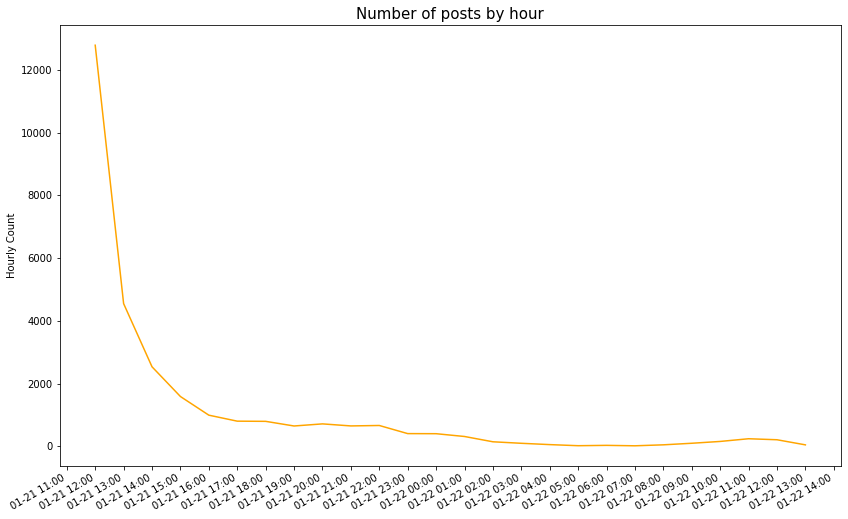

In [9]:
plt.figure(figsize=(14,9))

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:00'))
plt.gcf().autofmt_xdate() # Rotation

plt.plot(time_count['time_by_hour'],time_count['content'], color='Orange')
plt.title('Number of posts by hour',fontsize=15)
plt.ylabel('Hourly Count')
plt.show()
# plt.savefig('./images/hourly_count.png')

<br>
<br>
<br>
<br>
<br>
<br>

## Most active users: How much danmus did most active users post in each minute

In [10]:
# select most active users
users = full_df.groupby('ID')['content'].count().reset_index().sort_values('content', ascending=False).reset_index(drop=True)
top_users = users[users['content'] >= 60]
top_users.head()

,ID,content
0,f432dd69,249
1,44a8a462,125
2,34b152e7,105
3,f10342c5,101
4,fefaa5ba,101


In [11]:
top_users_df = pd.merge(top_users, full_df[['ID', 'vid_time', 'comment_time', 'content']], on='ID')
top_users_df['min'] = top_users_df['vid_time'] // 60

In [12]:
showup_time = top_users_df.groupby(['ID', 'min']).size().reset_index()
showup_time.columns = ['ID', 'Min', 'Count']
showup_time['Min'] = showup_time['Min'].astype(int)

In [13]:
showup_time.sort_values('Count', ascending=False).head()

,ID,Min,Count
108,44a8a462,33,60
107,44a8a462,32,31
393,e7a8242f,27,31
439,f432dd69,14,27
204,896f0ddc,12,24


In [14]:
heatmap1_data = pd.pivot_table(showup_time, values='Count', index=['ID'], columns='Min')

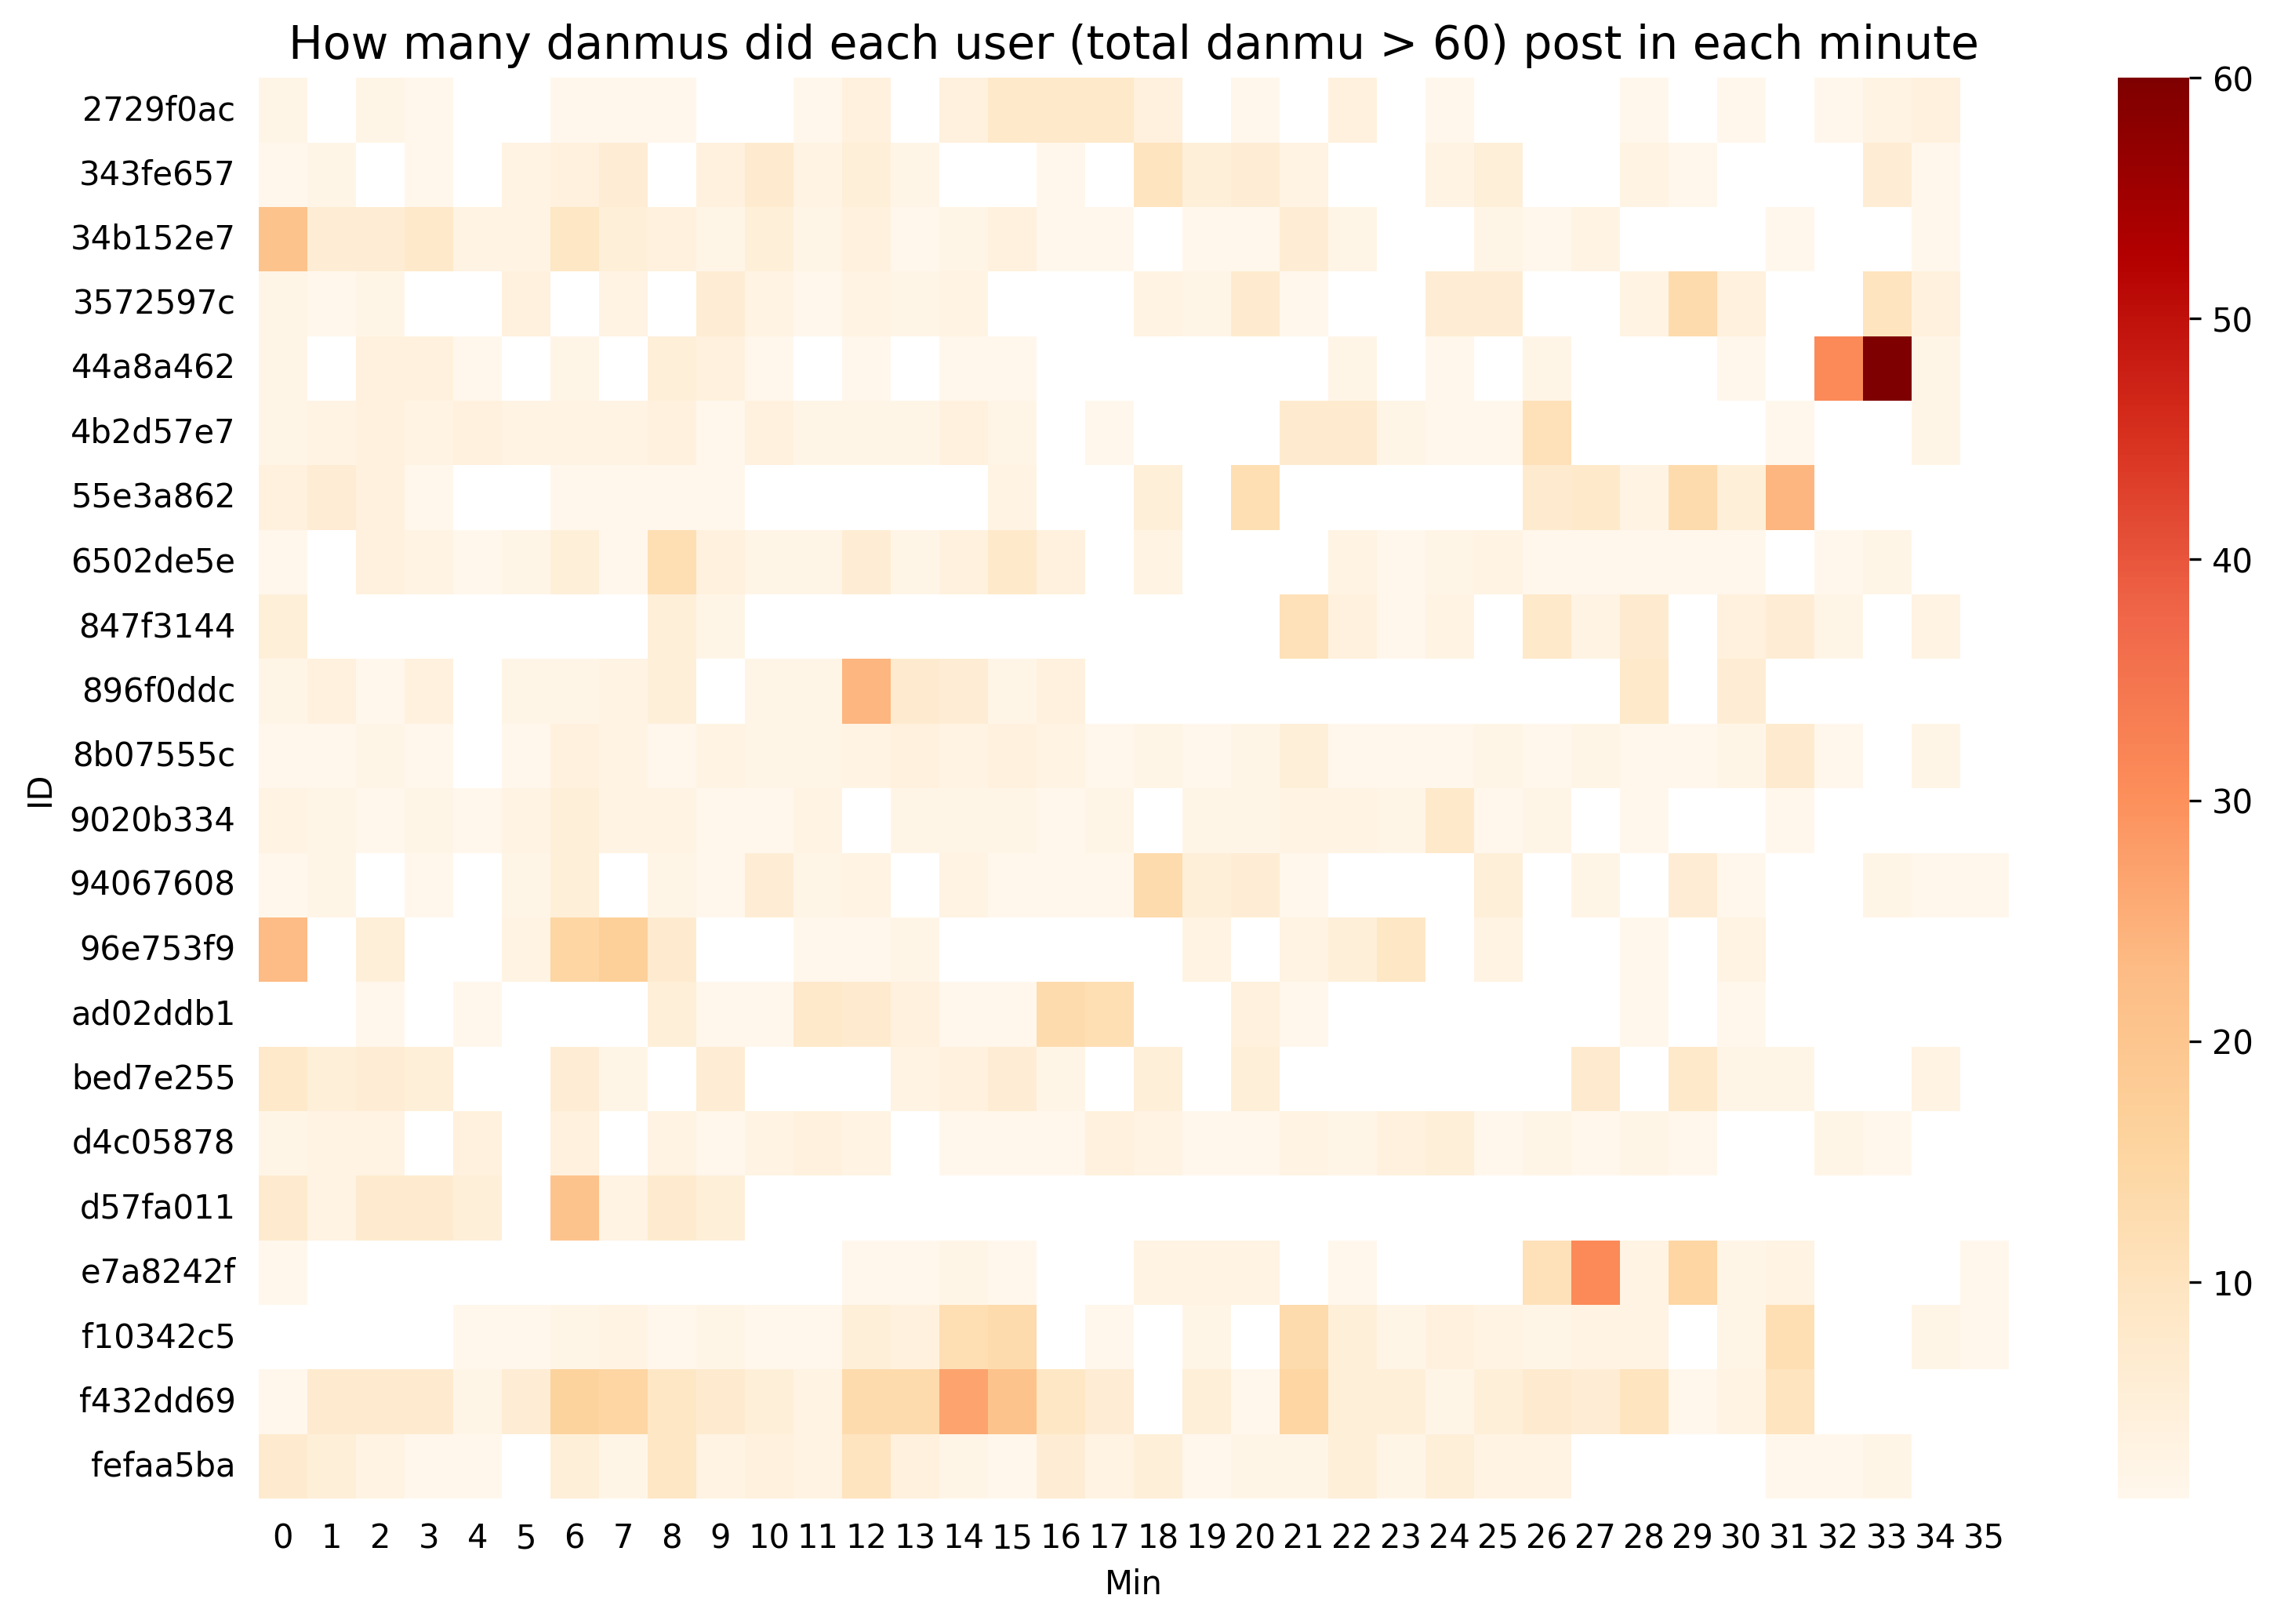

In [15]:
plt.figure(figsize=(12,8), dpi= 300)
ax = sns.heatmap(heatmap1_data, cmap="OrRd", annot=False)
ax.tick_params(left=False, bottom=False)

plt.title('How many danmus did each user (total danmu > 60) post in each minute', fontsize=14)
plt.show()

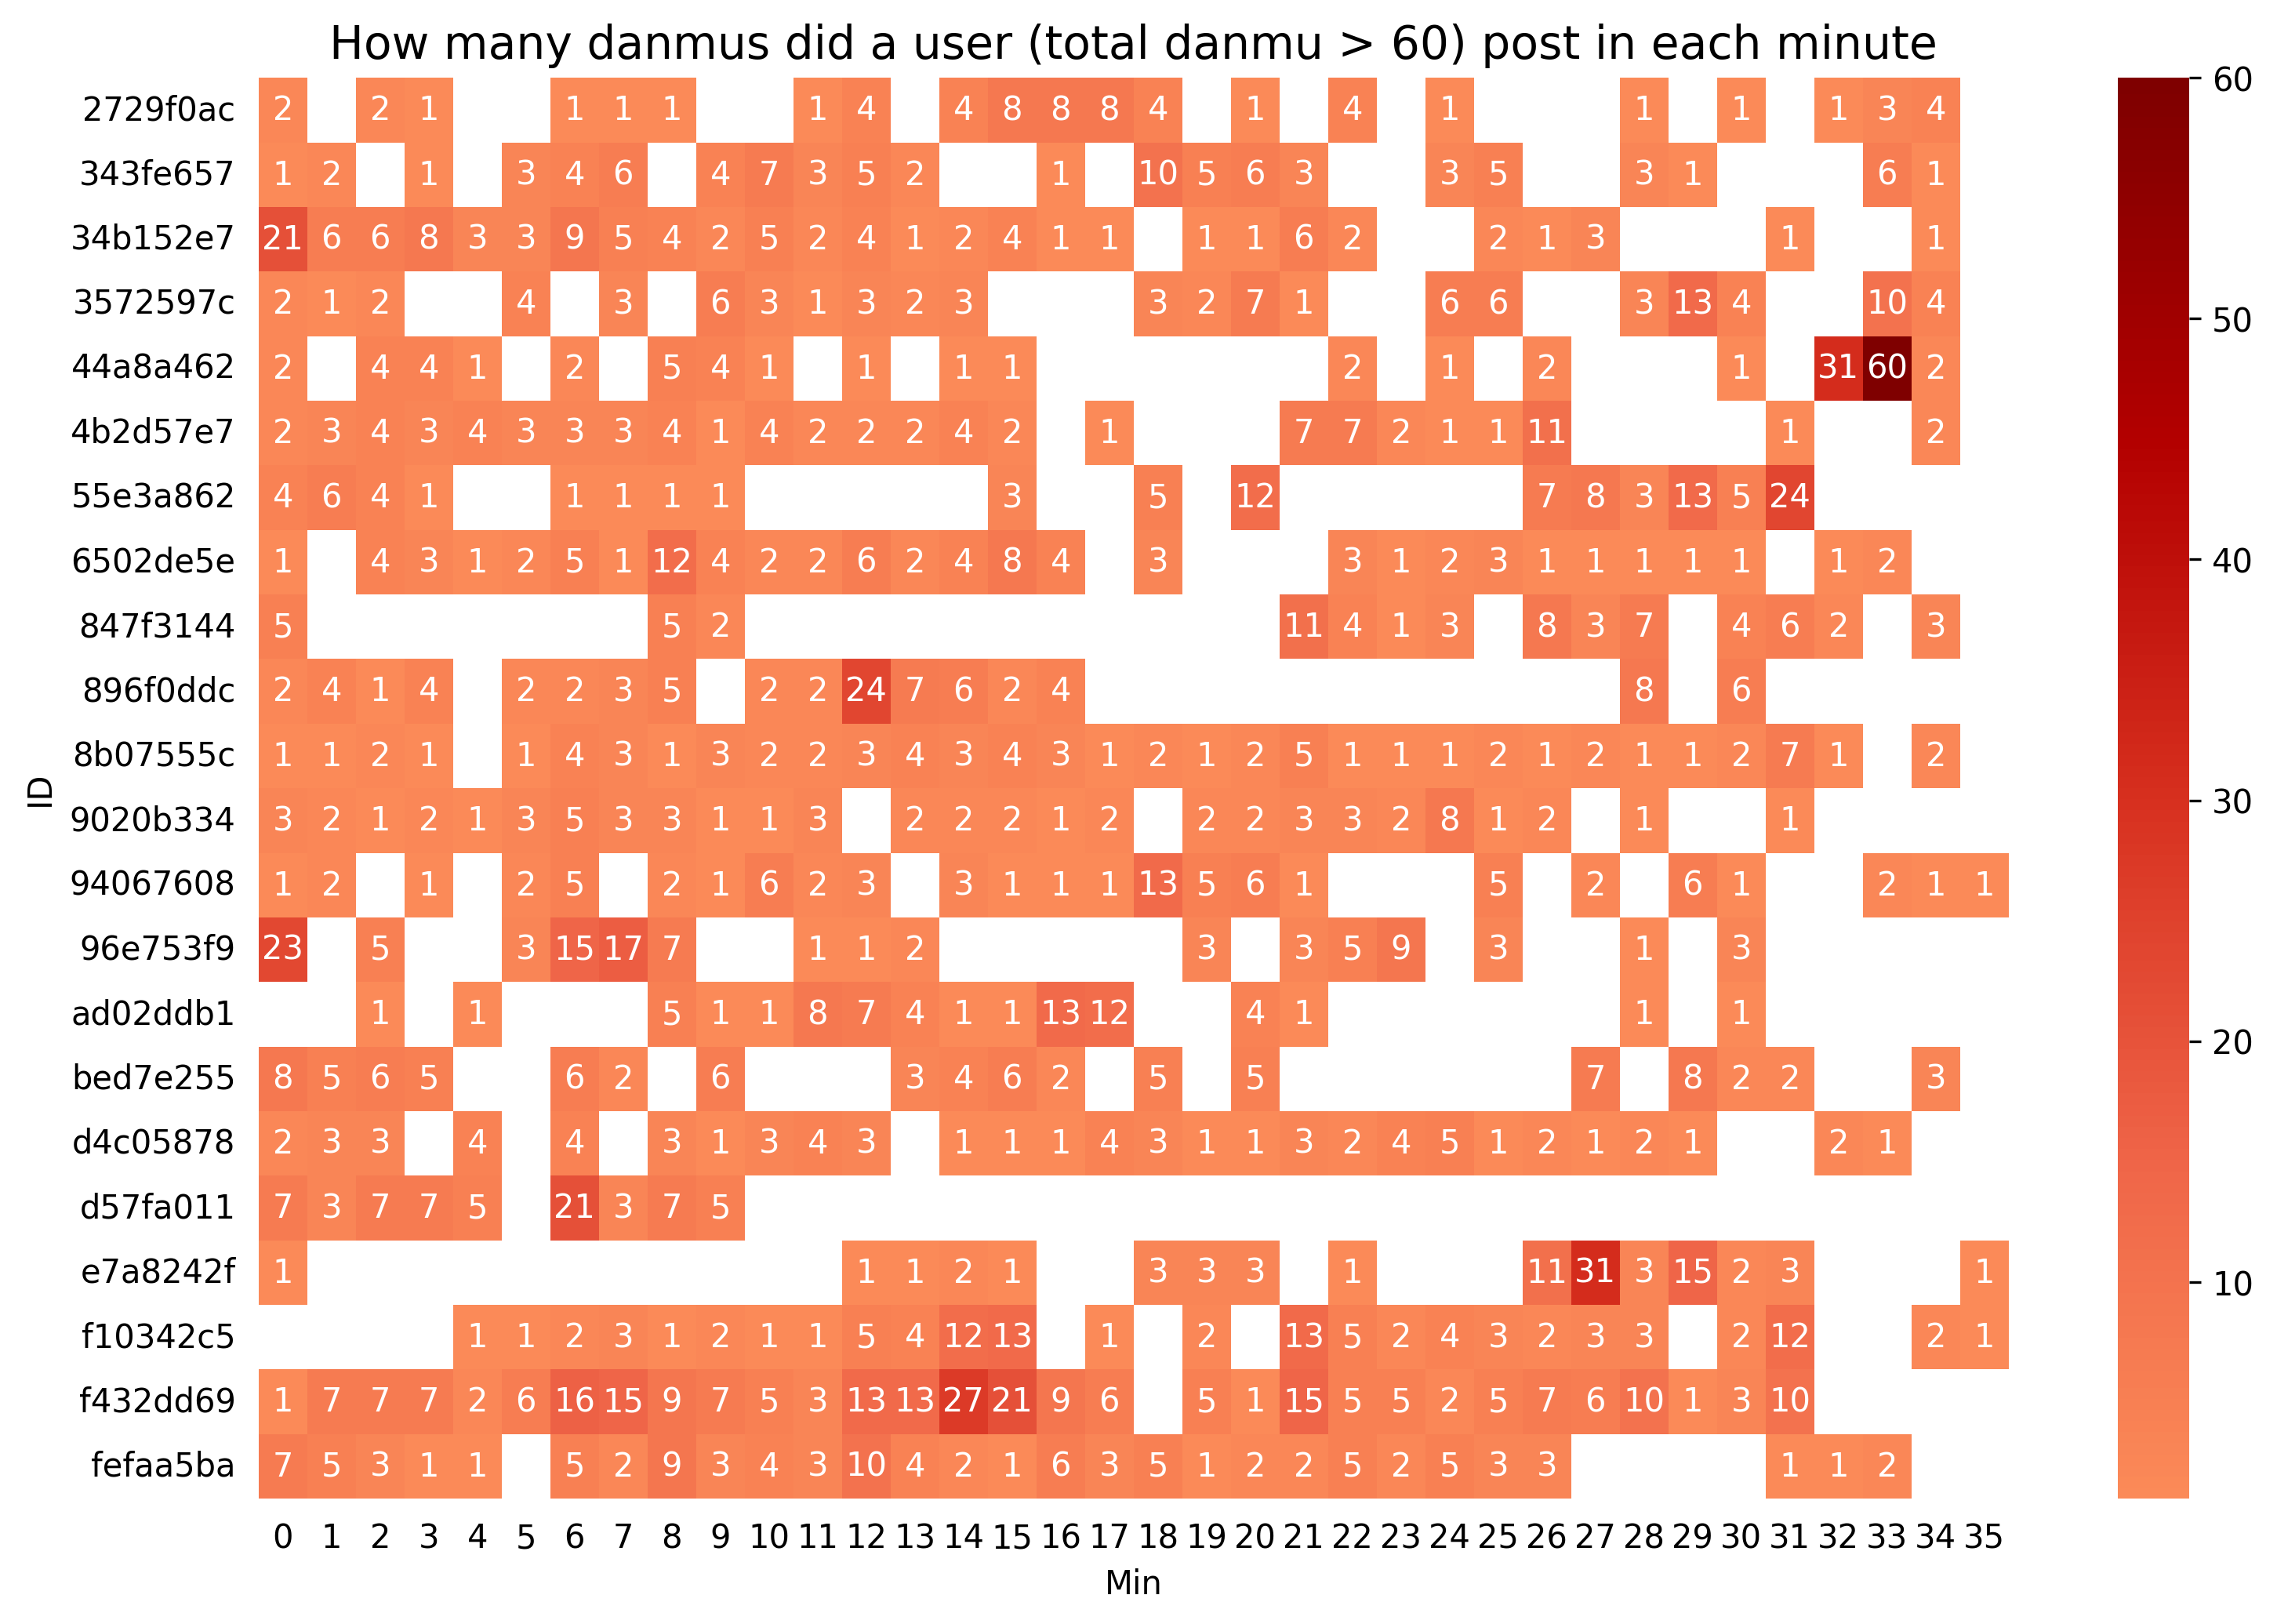

In [16]:
plt.figure(figsize=(12,8), dpi= 300)
ax = sns.heatmap(heatmap1_data, cmap="OrRd", annot=True,  center=0)
ax.tick_params(left=False, bottom=False)

plt.title('How many danmus did a user (total danmu > 60) post in each minute', fontsize=14)
plt.show()